In [1]:
# libraries
import numpy as np
import pandas as pd
import pyreadr
import scipy
import matplotlib.pyplot as plt
import seaborn 

In [2]:
perfomances_dt2 = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/perfomances_dt2.rds")[None] # also works for RData
percent20_dt = pyreadr.read_r("/home/germanm2/n_policy_box/Data/files_rds/percent20_dt.rds")[None] # also works for RData
percent20_dt = percent20_dt[['NMS','policy']]

In [9]:
#add the baselevel
df = pd.DataFrame({'NMS': ['static'],
                   'policy': ['ratio_5']})
percent20_dt = percent20_dt.append(df, ignore_index=True)

# #Filter the rows that are in the 20 percent
keys = list(percent20_dt.columns.values)
i1 = perfomances_dt2.set_index(keys).index
i2 = percent20_dt.set_index(keys).index
perfomances_opt_df = perfomances_dt2[i1.isin(i2)].reset_index()

# #Rename the base-level
perfomances_opt_df.loc[perfomances_opt_df.policy == "ratio_5","policy"]= "nopolicy_0"
perfomances_opt_df.loc[perfomances_opt_df.region == "1","region_lab"]= '3-South'
perfomances_opt_df.loc[perfomances_opt_df.region == "2","region_lab"]= '2-Central'
perfomances_opt_df.loc[perfomances_opt_df.region == "3","region_lab"]= '1-North'
perfomances_opt_df['net_balance'] = perfomances_opt_df['P']+perfomances_opt_df['G']

In [10]:
#Average across z
# perfomances_opt_df2 = perfomances_opt_df.groupby(['policy', 'NMS', 'id_10', 'id_field'], as_index=False).mean()
perfomances_opt_df2 = perfomances_opt_df.groupby(['region_lab','policy', 'NMS', 'id_10', 'id_field']).mean().reset_index().drop(['index'], axis=1)

# Split value columns 
perfomances_opt_df2['policy_name'] = perfomances_opt_df2["policy"].str.split("_", n = 1, expand = True)[0]  
perfomances_opt_df2['policy_val'] = perfomances_opt_df2["policy"].str.split("_", n = 1, expand = True)[1]  
perfomances_opt_df2 = perfomances_opt_df2[perfomances_opt_df2.L < 100]
perfomances_opt_df2['randNumCol'] = np.random.randint(-5,5, size=len(perfomances_opt_df2))
# perfomances_opt_df2.loc[perfomances_opt_df2.NMS != 'static', 'randNumCol']=0
# perfomances_opt_df2.N_fert = perfomances_opt_df2.N_fert+perfomances_opt_df2.randNumCol
# perfomances_opt_df2.loc[perfomances_opt_df2.NMS != 'static']

In [11]:
plot_dt_long = pd.melt(perfomances_opt_df2, id_vars=['region_lab','policy_name', 'NMS'], value_vars=['N_fert', 'L', 'P','net_balance'])
# plot_dt_long['policy_name'][plot_dt_long['policy_name'] == 'red'] = 'reduction'
plot_dt_long['policy_NMS'] = plot_dt_long['policy_name']+'_'+ plot_dt_long['NMS']
plot_dt_long

,region_lab,policy_name,NMS,variable,value,policy_NMS
0,1-North,bal,dynamic,N_fert,141.250000,bal_dynamic
1,1-North,bal,dynamic,N_fert,142.500000,bal_dynamic
2,1-North,bal,dynamic,N_fert,152.500000,bal_dynamic
3,1-North,bal,dynamic,N_fert,168.750000,bal_dynamic
4,1-North,bal,dynamic,N_fert,168.750000,bal_dynamic
...,...,...,...,...,...,...
80147,3-South,red,dynamic,net_balance,1427.825331,red_dynamic
80148,3-South,red,dynamic,net_balance,1482.842450,red_dynamic
80149,3-South,red,dynamic,net_balance,1482.943866,red_dynamic
80150,3-South,red,dynamic,net_balance,1423.295260,red_dynamic


/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/anaconda3/envs/GEOANN/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


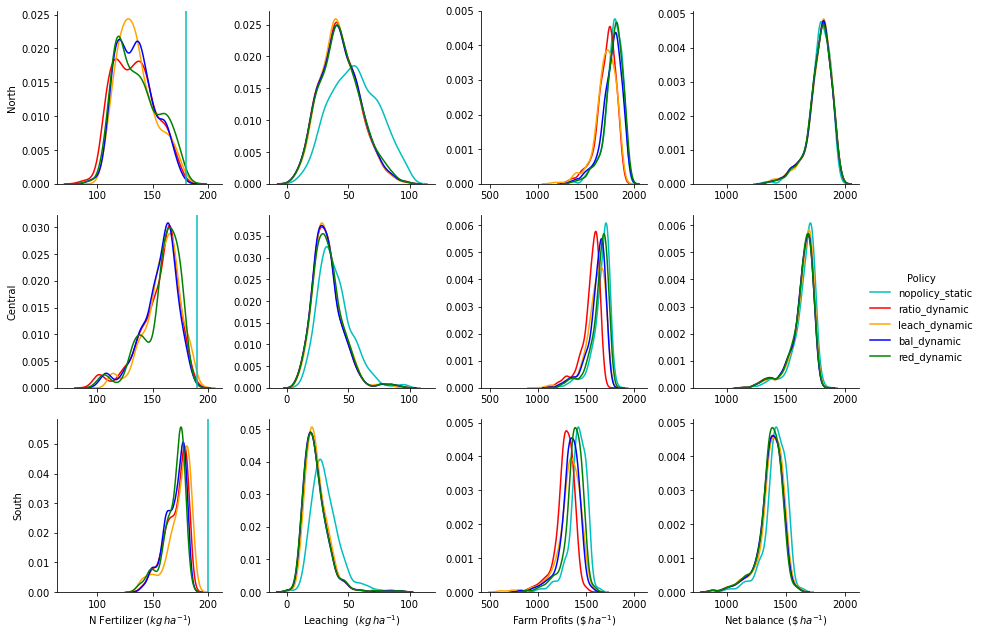

In [16]:
# kw = {'color': ['green', 'green'], 'linestyle' : ["-","--"]}
kw = {'color': ['c', 'red', 'orange', 'blue', 'green']}

graph = seaborn.FacetGrid(plot_dt_long, row ='region_lab', col ='variable', hue ='policy_NMS', 
                          sharey = False, sharex = 'col', margin_titles=False,  hue_kws=kw, 
                          hue_order = ['nopolicy_static', 'ratio_dynamic', 'leach_dynamic', 'bal_dynamic', 'red_dynamic'])
graph.map(seaborn.kdeplot, "value").add_legend(title = 'Policy')  

graph.axes[2,0].set_xlabel(r'N Fertilizer $(kg\/ ha^{-1})$')
graph.axes[2,1].set_xlabel(r'Leaching  $(kg\/ ha^{-1})$')
graph.axes[2,2].set_xlabel(r'Farm Profits $(\$ \/ ha^{-1})$')
graph.axes[2,3].set_xlabel(r'Net balance $(\$ \/ ha^{-1})$')

graph.axes[0,0].set_ylabel('North')
graph.axes[1,0].set_ylabel('Central')
graph.axes[2,0].set_ylabel('South')

graph.axes[0,0].axvline(180, ls='-', color = 'c')
graph.axes[1,0].axvline(190, ls='-', color = 'c')
graph.axes[2,0].axvline(200, ls='-', color = 'c')

axes = graph.axes.flatten()
for axes_n  in axes:
    axes_n.set_title("")
    axes_n.tick_params(labelbottom=True)    
    
plot_file_name = "/home/germanm2/n_policy_box/Data/figures/pdf_variables.png"
plt.savefig(plot_file_name, dpi=300)

In [ ]:
tips = sns.load_dataset("tips")
g = sns.FacetGrid(tips, col="smoker", row="time", sharey="col")
g.map(plt.hist, "total_bill")

In [ ]:
# BARCHART P_diff by base-level L 

# red_labels_4 = ['silver', 'gold', 'platinum', 'diamond']
# red_bins = [0, 70000, 100000, 130000, 200000]
# df['red_ex1'] = pd.red(df['ext price'], bins=red_bins, labels=red_labels_4)
cut_bins = [0, 25, 50, 70, 160]

perfomances_opt_df2['L_0_bin'] = pd.cut(perfomances_opt_df2['L_0'], bins=cut_bins)

bar_dt = perfomances_opt_df2[perfomances_opt_df2.NMS == 'dynamic'].groupby(['policy_name', 'NMS', 'L_0_bin'], 
                                                                     as_index=False).agg(
                      {'P_diff':['mean','std', 'count']}).reset_index()

bar_ratio_dt = bar_dt[(bar_dt['policy_name'] == 'ratio') ]
bar_leach_dt = bar_dt[(bar_dt['policy_name'] == 'leach')]
bar_nred_dt = bar_dt[(bar_dt['policy_name'] == 'red')]
bar_bal_dt = bar_dt[(bar_dt['policy_name'] == 'bal') ]
bar_nopolicy_dt = bar_dt[(bar_dt['policy_name'] == 'nopolicy')]

fig, ax = plt.subplots()

pos1 = [0,6,12,18]
pos2 = [x + 1 for x in pos1] 
pos3 = [x + 2 for x in pos1]
pos4 = [x + 3 for x in pos1]
pos5 = [x + 4 for x in pos1]

ax.bar(x = pos1, height = bar_nopolicy_dt['P_diff']['mean'],color = 'c', label = 'dynamic_nopolicy',
      yerr=bar_nopolicy_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos2, height = bar_ratio_dt['P_diff']['mean'],color = 'r', label = 'dynamic_ratio',
      yerr=bar_ratio_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos3, height = bar_leach_dt['P_diff']['mean'],color = 'y', label = 'dynamic_leach',
      yerr=bar_leach_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos4, height = bar_bal_dt['P_diff']['mean'],color = 'b', label = 'dynamic_balance',
      yerr=bar_nred_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos5, height = bar_nred_dt['P_diff']['mean'],color = 'g', label = 'dynamic_reduction',
      yerr=bar_nred_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

count_dt = bar_dt[bar_dt.policy_name == 'bal'].reset_index()
count_dt = bar_dt[bar_dt.policy_name == 'bal'].reset_index()
for counter, value in enumerate(pos2):    
    ax.annotate(count_dt.P_diff['count'][counter], xy=(value, 2), xycoords='data', textcoords='data')    
    
plt.xlabel("Base-level leaching (kg/ha)", size = 12)
plt.ylabel("Profits difference (kg/ha)", size = 12)
plt.gcf().text(0, 0.85, 'a)', fontsize=16)
x_labels = [str(cut_bins[0])+'-'+ str(cut_bins[1]), str(cut_bins[1])+'-'+ str(cut_bins[2]), str(cut_bins[2])+'-'+ str(cut_bins[3]), str(cut_bins[3])+'-'+ str(cut_bins[4])]
plt.xticks(pos3, x_labels)
# plt.legend(ncol=2)
plot_file_name = "/home/germanm2/n_policy_box/Data/figures/field_effects_bar_a.png"
plt.savefig(plot_file_name, dpi=300)

In [ ]:
# BARCHART L change by base-level L 

perfomances_opt_df2['L_0_bin'] = pd.cut(perfomances_opt_df2['L_0'], bins=cut_bins)
perfomances_opt_df2

bar_dt = perfomances_opt_df2[perfomances_opt_df2.NMS == 'dynamic'].groupby(['policy_name', 'NMS', 'L_0_bin'], 
                                                                     as_index=False).agg(
                      {'L_diff':['mean','std', 'count']}).reset_index()

bar_ratio_dt = bar_dt[(bar_dt['policy_name'] == 'ratio') ]
bar_leach_dt = bar_dt[(bar_dt['policy_name'] == 'leach')]
bar_nred_dt = bar_dt[(bar_dt['policy_name'] == 'red')]
bar_bal_dt = bar_dt[(bar_dt['policy_name'] == 'bal')]
bar_nopolicy_dt = bar_dt[(bar_dt['policy_name'] == 'nopolicy')]

fig, ax = plt.subplots()

pos1 = [0,6,12,18]
pos2 = [x + 1 for x in pos1] 
pos3 = [x + 2 for x in pos1]
pos4 = [x + 3 for x in pos1]
pos5 = [x + 4 for x in pos1]

ax.bar(x = pos1, height = bar_nopolicy_dt['L_diff']['mean'],color = 'c', label = 'dynamic_nopolicy',
      yerr=bar_nopolicy_dt['L_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos2, height = bar_ratio_dt['L_diff']['mean'],color = 'r',label = 'dynamic_ratio',
      yerr=bar_ratio_dt['L_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos3, height = bar_leach_dt['L_diff']['mean'],color = 'y',label = 'dynamic_leach',
      yerr=bar_leach_dt['L_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos4, height = bar_bal_dt['L_diff']['mean'],color = 'b',label = 'dynamic_bal',
      yerr=bar_nred_dt['L_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos5, height = bar_nred_dt['L_diff']['mean'],color = 'g',label = 'dynamic_reduction',
      yerr=bar_nred_dt['L_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

count_dt = bar_dt[bar_dt.policy_name == 'bal'].reset_index()
for counter, value in enumerate(pos2):    
    ax.annotate(count_dt.L_diff['count'][counter], xy=(value, 0.2), xycoords='data', textcoords='data')    
    
plt.gcf().text(0, 0.85, 'b)', fontsize=16)
plt.xlabel("Base-level leaching (kg/ha)", size = 12)
plt.ylabel("Leaching difference (kg/ha)", size = 12)

plt.xticks(pos3, x_labels)

plt.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')

plot_file_name = "/home/germanm2/n_policy_box/Data/figures/field_effects_bar_b.png"
plt.savefig(plot_file_name, dpi=300, bbox_inches='tight')

In [ ]:
hist = perfomances_opt_df2['P_0'].hist(bins=5)

In [ ]:
# BARCHART P_diff change by base-level L

# red_labels_4 = ['silver', 'gold', 'platinum', 'diamond']
# red_bins = [0, 70000, 100000, 130000, 200000]
# df['red_ex1'] = pd.red(df['ext price'], bins=red_bins, labels=red_labels_4)
cut_bins = [1200, 1500, 1650,1750, 2000]

perfomances_opt_df2['P_0_bin'] = pd.cut(perfomances_opt_df2['P_0'], bins=cut_bins)

bar_dt = perfomances_opt_df2[perfomances_opt_df2.NMS == 'dynamic'].groupby(['policy_name', 'NMS', 'P_0_bin'], 
                                                                     as_index=False).agg(
                      {'P_diff':['mean','std', 'count']}).reset_index()
bar_dt

bar_ratio_dt = bar_dt[(bar_dt['policy_name'] == 'ratio') ]
bar_leach_dt = bar_dt[(bar_dt['policy_name'] == 'leach')]
bar_nred_dt = bar_dt[(bar_dt['policy_name'] == 'red')]
bar_bal_dt = bar_dt[(bar_dt['policy_name'] == 'bal')]
bar_nopolicy_dt = bar_dt[(bar_dt['policy_name'] == 'nopolicy')]

fig, ax = plt.subplots()

pos1 = [0,6,12,18]
pos2 = [x + 1 for x in pos1] 
pos3 = [x + 2 for x in pos1]
pos4 = [x + 3 for x in pos1]
pos5 = [x + 4 for x in pos1]

ax.bar(x = pos1, height = bar_nopolicy_dt['P_diff']['mean'],color = 'c', label = 'dynamic_nopolicy',
      yerr=bar_nopolicy_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos2, height = bar_ratio_dt['P_diff']['mean'],color = 'r', label = 'dynamic_ratio',
      yerr=bar_ratio_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos3, height = bar_leach_dt['P_diff']['mean'],color = 'y', label = 'dynamic_leach',
      yerr=bar_leach_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos4, height = bar_bal_dt['P_diff']['mean'],color = 'b', label = 'dynamic_bal',
      yerr=bar_nred_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

ax.bar(x = pos5, height = bar_nred_dt['P_diff']['mean'],color = 'g', label = 'dynamic_reduction',
      yerr=bar_nred_dt['P_diff']['std'],align='center', alpha=1, ecolor='black', capsize=10)

count_dt = bar_dt[bar_dt.policy_name == 'bal'].reset_index()
for counter, value in enumerate(pos2):    
    ax.annotate(count_dt.P_diff['count'][counter], xy=(value, 2), xycoords='data', textcoords='data')    

    
# plt.legend(ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel("Profits ($/ha)", size = 12)
plt.ylabel("Profits difference (kg/ha)", size = 12)
plt.gcf().text(0, 0.85, 'c)', fontsize=16)

x_labels = [str(cut_bins[0])+'-'+ str(cut_bins[1]), str(cut_bins[1])+'-'+ str(cut_bins[2]), str(cut_bins[2])+'-'+ str(cut_bins[3]), str(cut_bins[3])+'-'+ str(cut_bins[4])]
plt.xticks(pos3, x_labels)

plot_file_name = "/home/germanm2/n_policy_box/Data/figures/field_effects_bar_c.png"
plt.savefig(plot_file_name, dpi=300)

In [ ]:
# ratio_1_dt = perfomances_opt_df2[(perfomances_opt_df2['policy_name'] == 'ratio') & (perfomances_dt5['NMS'] == '1')]
# leach_1_dt = perfomances_dt5[(perfomances_dt5['policy_name'] == 'leach') & (perfomances_dt5['NMS'] == '1')]
# nred_1_dt = perfomances_dt5[(perfomances_dt5['policy_name'] == 'nred') & (perfomances_dt5['NMS'] == '1')]
# subs_1_dt = perfomances_dt5[(perfomances_dt5['policy_name'] == 'subs') & (perfomances_dt5['NMS'] == '1')]

ratio_2_dt = perfomances_opt_df2[(perfomances_opt_df2['policy_name'] == 'ratio') & (perfomances_opt_df2['NMS'] == 'dynamic')]
leach_2_dt = perfomances_opt_df2[(perfomances_opt_df2['policy_name'] == 'leach') & (perfomances_opt_df2['NMS'] == 'dynamic')]
nred_2_dt = perfomances_opt_df2[(perfomances_opt_df2['policy_name'] == 'red') & (perfomances_opt_df2['NMS'] == 'dynamic')]
bal_2_dt = perfomances_opt_df2[(perfomances_opt_df2['policy_name'] == 'bal') & (perfomances_opt_df2['NMS'] == 'dynamic')]
nopolicy_2_dt = perfomances_opt_df2[(perfomances_opt_df2['policy_name'] == 'nopolicy') & (perfomances_opt_df2['NMS'] == 'dynamic')]

In [ ]:
# Profits change by base-level P
 
fig, ax = plt.subplots()
# ax.plot(ratio_1_dt['L_change'], ratio_1_dt['C'], color = 'r', label = 'ratio_NMS1')
# ax.plot(leach_1_dt['L_change'], leach_1_dt['C'], color = 'g', label = 'leach_NMS1')
# ax.plot(nred_1_dt['L_change'], nred_1_dt['C'], color = 'b', label = 'target_NMS1')
ax.scatter(ratio_2_dt['P_0'], ratio_2_dt['P_diff'], color = 'r',  label = 'dynamic-ratio', s = 10)
ax.scatter(leach_2_dt['P_0'], leach_2_dt['P_diff'], color = 'g', label = 'leach', s = 10)
ax.scatter(nred_2_dt['P_0'], nred_2_dt['P_diff'], color = 'b', label = 'reduction', s = 10)
ax.scatter(nopolicy_2_dt['P_0'], nopolicy_2_dt['P_diff'], color = 'y', label = 'dynamic-nopolicy', s = 10)
# ax.plot(subs_2_dt['L_change'], subs_2_dt['C'], color = 'y', label = 'subs_dynamic')

plt.legend()

plt.xlabel("Base-level Profits (kg/ha)", size = 12)
plt.ylabel("Profits difference ($/ha)", size = 12)
plt.gcf().text(0, 0.85, 'c)', fontsize=16)
# ax.set_xticks((np.arange(0, 21, 1)))

plot_file_name = "/home/germanm2/n_policy_box/Data/figures/field_effects_scatter_c.png"
plt.savefig(plot_file_name, dpi=300)

In [ ]:
leach_2_dt

In [ ]:
# Profits change by base-level L
 
fig, ax = plt.subplots()
# ax.plot(ratio_1_dt['L_change'], ratio_1_dt['C'], color = 'r', label = 'ratio_NMS1')
# ax.plot(leach_1_dt['L_change'], leach_1_dt['C'], color = 'g', label = 'leach_NMS1')
# ax.plot(nred_1_dt['L_change'], nred_1_dt['C'], color = 'b', label = 'target_NMS1')
ax.scatter(ratio_2_dt['L_0'], ratio_2_dt['P_diff'], color = 'r',  label = 'dynamic-ratio', s = 10)
ax.scatter(leach_2_dt['L_0'], leach_2_dt['P_diff'], color = 'g', label = 'dynamic-leach', s = 10)
ax.scatter(nred_2_dt['L_0'], nred_2_dt['P_diff'], color = 'b', label = 'dynamic-reduction', s = 10)
ax.scatter(nopolicy_2_dt['L_0'], nopolicy_2_dt['P_diff'], color = 'y', label = 'dynamic_nopolicy', s = 10)
# ax.plot(subs_2_dt['L_change'], subs_2_dt['C'], color = 'y', label = 'subs_NMS2')

plt.legend()

plt.xlabel("Base-level leaching (kg/ha)", size = 12)
plt.ylabel("Profits difference ($/ha)", size = 12)
plt.gcf().text(0, 0.85, 'a)', fontsize=16)
# ax.set_xticks((np.arange(0, 21, 1)))
plot_file_name = "/home/germanm2/n_policy_box/Data/figures/field_effects_scatter_a.png"
plt.savefig(plot_file_name, dpi=300)

In [ ]:
# L change by base-level L
 
fig, ax = plt.subplots()
# ax.plot(ratio_1_dt['L_change'], ratio_1_dt['C'], color = 'r', label = 'ratio_NMS1')
# ax.plot(leach_1_dt['L_change'], leach_1_dt['C'], color = 'g', label = 'leach_NMS1')
# ax.plot(nred_1_dt['L_change'], nred_1_dt['C'], color = 'b', label = 'target_NMS1')
ax.scatter(ratio_2_dt['L_0'], ratio_2_dt['L_diff'], color = 'r',  label = 'dynamic-ratio', s = 10)
ax.scatter(leach_2_dt['L_0'], leach_2_dt['L_diff'], color = 'g', label = 'dynamic-leach', s = 10)
ax.scatter(nred_2_dt['L_0'], nred_2_dt['L_diff'], color = 'b', label = 'dynamic-reduction', s = 10)
ax.scatter(nopolicy_2_dt['L_0'], nopolicy_2_dt['L_diff'], color = 'y', label = 'dynamic-nopolicy', s = 10)
plt.legend()

plt.xlabel("Base-level leaching (kg/ha)", size = 12)
plt.ylabel("Leaching difference (kg/ha)", size = 12)
plt.gcf().text(0, 0.85, 'b)', fontsize=16)
# ax.set_xticks((np.arange(0, 21, 1)))
plot_file_name = "/home/germanm2/n_policy_box/Data/figures/field_effects_scatter_b.png"
plt.savefig(plot_file_name, dpi=300)

In [ ]:
perfomances_opt_df2

In [ ]:
import seaborn as sns

sns.distplot(nopolicy_2_dt['P_diff'], hist = False, kde = True,color = 'y', kde_kws = {'linewidth': 3}, label = 'dynamic_nopolicy')
sns.distplot(ratio_2_dt['P_diff'], hist = False, kde = True,color = 'r', kde_kws = {'linewidth': 3}, label = 'dynamic-ratio')
sns.distplot(leach_2_dt['P_diff'], hist = False, kde = True,color = 'g', kde_kws = {'linewidth': 3}, label = 'dynamic-leach')
sns.distplot(bal_2_dt['P_diff'], hist = False, kde = True,color = 'c', kde_kws = {'linewidth': 3}, label = 'dynamic-bal')
sns.distplot(nred_2_dt['P_diff'], hist = False, kde = True,color = 'b', kde_kws = {'linewidth': 3}, label = 'dynamic-reduction')

# Plot formatting
plt.legend(prop={'size': 16})
# plt.title('Density Plot with Multiple Airlines')
plt.xlabel('Profits difference ($/ha)')
plt.ylabel('Density')

In [ ]:
perfomances_opt_df[perfomances_opt_df.NMS == '1']

In [ ]:
ratio_2_dt = perfomances_dt2[(perfomances_dt2.policy == 'ratio_11') & (perfomances_dt2.NMS == '2')]

ratio_2_dt

In [ ]:
pd.melt(ratio_2_dt, id_vars=['policy', 'id_10', 'id_field', 'z','NMS'], value_vars=['Y_corn', 'Y_soy', , 'L1' ,'L2',
                                                                                    'N_fert', 'P', 'G'])